## <a id='toc1_1_'></a>[Zadanie:](#toc0_)

Proszę spróbować przeprowadzić taki proces regularyzacji modeli dla innego, nietrywialnego zbioru uczącego.

In [208]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)
print('GPU Name : ',tf.config.list_physical_devices('GPU'))

from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
LABELS= ['0', '1']

TensorFlow version: 2.16.1
Keras version: 3.0.5
GPU Name :  []


## <a id='toc1_2_'></a>[Visualization functions](#toc0_)

In [209]:
# Define the confusion matrix for the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['acc']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
def print_val_accuracies(history1, history2, history3):
    val_accuracy1 = history1.history['val_acc']
    val_accuracy2 = history2.history['val_acc']
    val_accuracy3 = history3.history['val_acc']

    argmax1 = np.argmax(val_accuracy1)
    argmax2 = np.argmax(val_accuracy2)
    argmax3 = np.argmax(val_accuracy3)

    print ('Max accuracy for model 1 is: ', val_accuracy1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
    print ('Max accuracy for model 2 is: ', val_accuracy2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
    print ('Max accuracy for model 3 is: ', val_accuracy3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

### <a id='toc1_2_1_'></a>[Dataset](#toc0_)
For this excercice I'm going to use Hotel Reservations dataset.
The goal is to predict whether the booking was cancelled or not.
https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

### <a id='toc1_2_2_'></a>[Load data](#toc0_)

In [210]:
data = pd.read_csv('HotelReservations.csv')
data.drop(['Booking_ID'], axis=1, inplace=True)
print(data.shape)
data.head()

(36275, 18)


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### <a id='toc1_2_3_'></a>[Reshape data](#toc0_)

In [211]:
data['booking_status'] = data['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

data = pd.get_dummies(data, columns=['market_segment_type'], prefix='market_segment')
data = pd.get_dummies(data, columns=['type_of_meal_plan'], prefix='meal_plan')
data['room_type_reserved'] = data['room_type_reserved'].str[-1].astype(int)
data.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,booking_status,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
0,2,0,1,2,0,1,224,2017,10,2,...,0,False,False,False,True,False,True,False,False,False
1,2,0,2,3,0,1,5,2018,11,6,...,0,False,False,False,False,True,False,False,False,True
2,1,0,2,1,0,1,1,2018,2,28,...,1,False,False,False,False,True,True,False,False,False
3,2,0,0,2,0,1,211,2018,5,20,...,1,False,False,False,False,True,True,False,False,False
4,2,0,1,1,0,1,48,2018,4,11,...,1,False,False,False,False,True,False,False,False,True


### <a id='toc1_2_4_'></a>[Normalize data](#toc0_)

```python
# min-max normalization:
df=(df-df.min())/(df.max()-df.min())
# mean normalization:
df=(df-df.mean())/df.std()
```

In [212]:
data_og = data.copy()

for column_name in data.columns:
    column = data[column_name]
    unique_values = column.unique()
    
    if sorted(unique_values) != [0, 1]:
        column = (column - column.mean()) / column.std()
        
    # change true/false to 1/0
    data[column_name] = column.astype(np.float32)
    
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,booking_status,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
0,0.298889,-0.261467,0.217398,-0.144801,0.0,-0.506404,1.614874,-2.137440,0.839230,-1.555641,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.298889,-0.261467,1.365974,0.563964,0.0,-0.506404,-0.933688,0.467837,1.164974,-1.097998,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.628953,-0.261467,1.365974,-0.853566,0.0,-0.506404,-0.980237,0.467837,-1.766723,1.419035,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.298889,-0.261467,-0.931177,-0.144801,0.0,-0.506404,1.463590,0.467837,-0.789491,0.503751,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.298889,-0.261467,0.217398,-0.853566,0.0,-0.506404,-0.433285,0.467837,-1.115235,-0.525945,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### <a id='toc1_2_5_'></a>[Train - Validate - Test split](#toc0_)

In [213]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop(columns = ['booking_status']), data['booking_status'], test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)
train_data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,no_of_special_requests,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
25629,0.298889,2.222092,1.365974,-0.853566,0.0,-0.506404,-0.689305,-2.137440,0.839230,0.160519,...,-0.788129,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
14473,0.298889,2.222092,0.217398,-0.853566,0.0,-0.506404,0.148578,0.467837,-0.138002,0.046108,...,1.755637,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
23720,0.298889,-0.261467,-0.931177,0.563964,0.0,-0.506404,4.047063,0.467837,0.513486,-0.869177,...,-0.788129,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5843,0.298889,-0.261467,1.365974,1.981494,0.0,-0.506404,1.277393,0.467837,0.187742,-0.869177,...,-0.788129,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
18709,-1.628953,-0.261467,-0.931177,-0.144801,0.0,-0.506404,1.195932,0.467837,-0.463746,-0.068303,...,-0.788129,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,0.298889,-0.261467,1.365974,-0.144801,0.0,-0.506404,-0.491472,-2.137440,1.490718,1.190214,...,1.755637,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6265,-1.628953,-0.261467,-0.931177,-0.144801,0.0,-0.506404,0.195127,-2.137440,0.839230,0.046108,...,-0.788129,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11284,0.298889,-0.261467,-0.931177,-0.144801,0.0,-0.506404,-0.933688,0.467837,-0.789491,0.961393,...,0.483754,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
860,0.298889,-0.261467,-0.931177,0.563964,0.0,-0.506404,1.486864,0.467837,-0.463746,-0.983588,...,-0.788129,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### <a id='toc1_2_6_'></a>[Class weights](#toc0_)

In [214]:
def calculate_class_weight(labels):
    count_of_labels = len(labels)
    count_of_positives = labels.sum()
    count_of_negatives = count_of_labels - count_of_positives
    
    positive_weight = count_of_labels /  (2 * count_of_positives)
    negative_weight = count_of_labels / (2 * count_of_negatives)
    
    return {0: negative_weight, 1: positive_weight}

In [215]:
class_weight = calculate_class_weight(data_og['booking_status'])
print(1 / class_weight[0] + 1 / class_weight[1])
print(f"Class weights: {class_weight}")

2.0
Class weights: {0: 0.7436449364493645, 1: 1.5260832982751367}


### <a id='toc1_2_7_'></a>[% of positive cases](#toc0_)

In [216]:
print(f"Positive cases in total: {data_og['booking_status'].sum()}, negative cases in total: {len(data_og['booking_status']) - data_og['booking_status'].sum()}, % of positive cases: {data_og['booking_status'].sum() / len(data_og['booking_status']) * 100:.2f}%")

Positive cases in total: 11885, negative cases in total: 24390, % of positive cases: 32.76%


## <a id='toc1_3_'></a>[Create NN](#toc0_)

In [217]:
def createNNModel(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(h1, activation='relu'))
    model.add(layers.Dense(h2, activation='relu'))
    model.add(layers.Dense(h3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [218]:
model1 = createNNModel(train_data.shape[1], 16, 16, 16)
model2 = createNNModel(train_data.shape[1], 32, 32, 32)
model3 = createNNModel(train_data.shape[1], 64, 64, 64)
model4 = createNNModel(train_data.shape[1], 128, 96, 64)

model4.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_221 (Dense)               │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,857 (85.38 KB)

 Trainable params: 21,857 (85.38 KB)

 Non-trainable params: 0 (0.00 B)

In [219]:
history1 = model1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history2 = model2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history3 = model3.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history4 = model4.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)

Epoch 1/150


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5837 - loss: 0.6427 - val_acc: 0.7535 - val_loss: 0.5378
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7568 - loss: 0.5222 - val_acc: 0.7883 - val_loss: 0.4671
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7724 - loss: 0.4785 - val_acc: 0.7852 - val_loss: 0.4502
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7794 - loss: 0.4568 - val_acc: 0.7866 - val_loss: 0.4439
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7809 - loss: 0.4530 - val_acc: 0.7891 - val_loss: 0.4332
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7858 - loss: 0.4424 - val_acc: 0.7869 - val_loss: 0.4357
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7932 - loss: 0.4312 - val_acc: 0.7896 - val_loss: 0.4298
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7922 - loss: 0.4319 - val_acc: 0.7932 - val_loss: 0.4239
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7914 - loss: 0.4

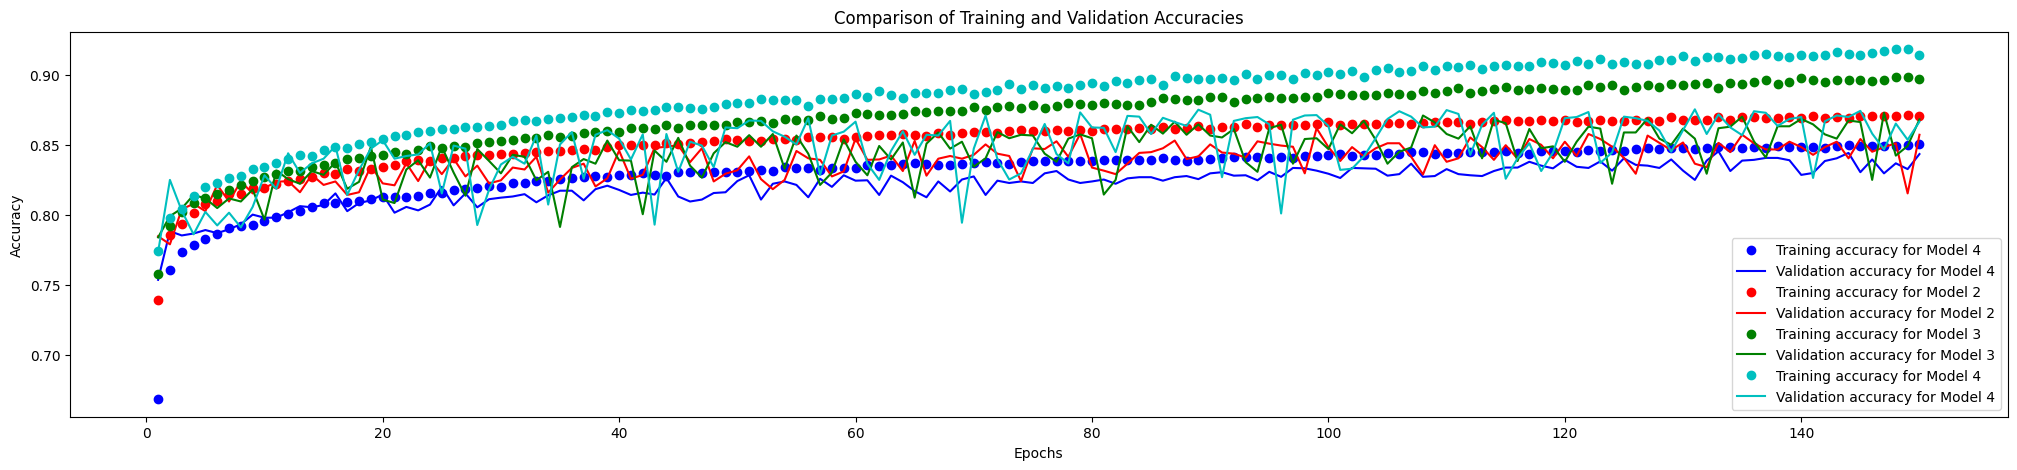

In [220]:
plot_accuracy_comparison(history1, history2, history3, history4, labels=['Model 4', 'Model 2', 'Model 3', 'Model 4'])

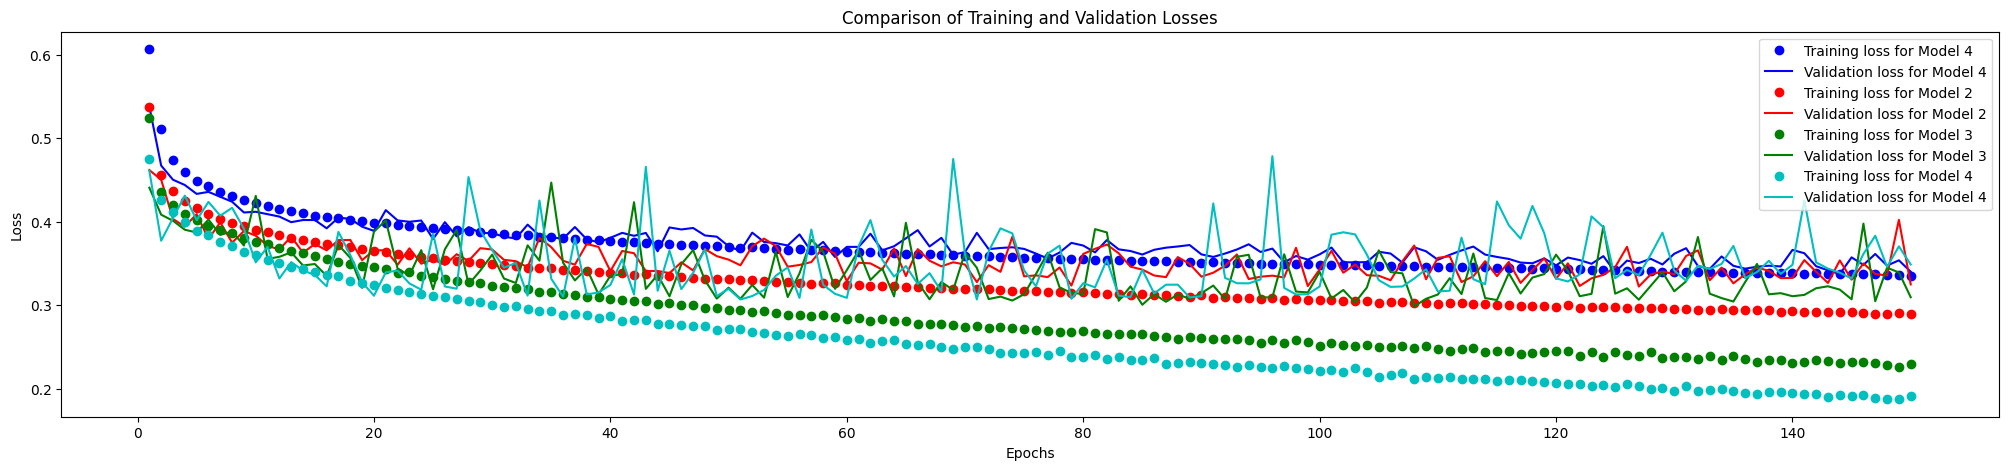

In [221]:
plot_loss_comparison(history1, history2, history3, history4, labels=['Model 4', 'Model 2', 'Model 3', 'Model 4'])

## <a id='toc1_4_'></a>[Regularization L1 & L2](#toc0_)

In [222]:
def createNNModelWithRegularizer(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16, kernel_regularizer=None):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [223]:
model_h1 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l1(0.0001))
model_h2 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001))
model_h1_h2 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l1_l2(l1=0.0001, l2=0.0001))

history_h1 = model_h1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_h2 = model_h2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_h1_h2 = model_h1_h2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6975 - loss: 0.7349 - val_acc: 0.7838 - val_loss: 0.6194
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7960 - loss: 0.6005 - val_acc: 0.8007 - val_loss: 0.5718
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8053 - loss: 0.5742 - val_acc: 0.8200 - val_loss: 0.5250
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8149 - loss: 0.5469 - val_acc: 0.7938 - val_loss: 0.5647
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8160 - loss: 0.5276 - val_acc: 0.8266 - val_loss: 0.4957
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8237 - loss: 0.5175 - val_acc: 0.7985 - val_loss: 0.5369
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8201 - loss: 0.5085 - val_acc: 0.8332 - val_loss: 0.4696
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8241 - loss: 0.4946 - val_acc: 0.8354 - val_loss: 0.4590
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8343

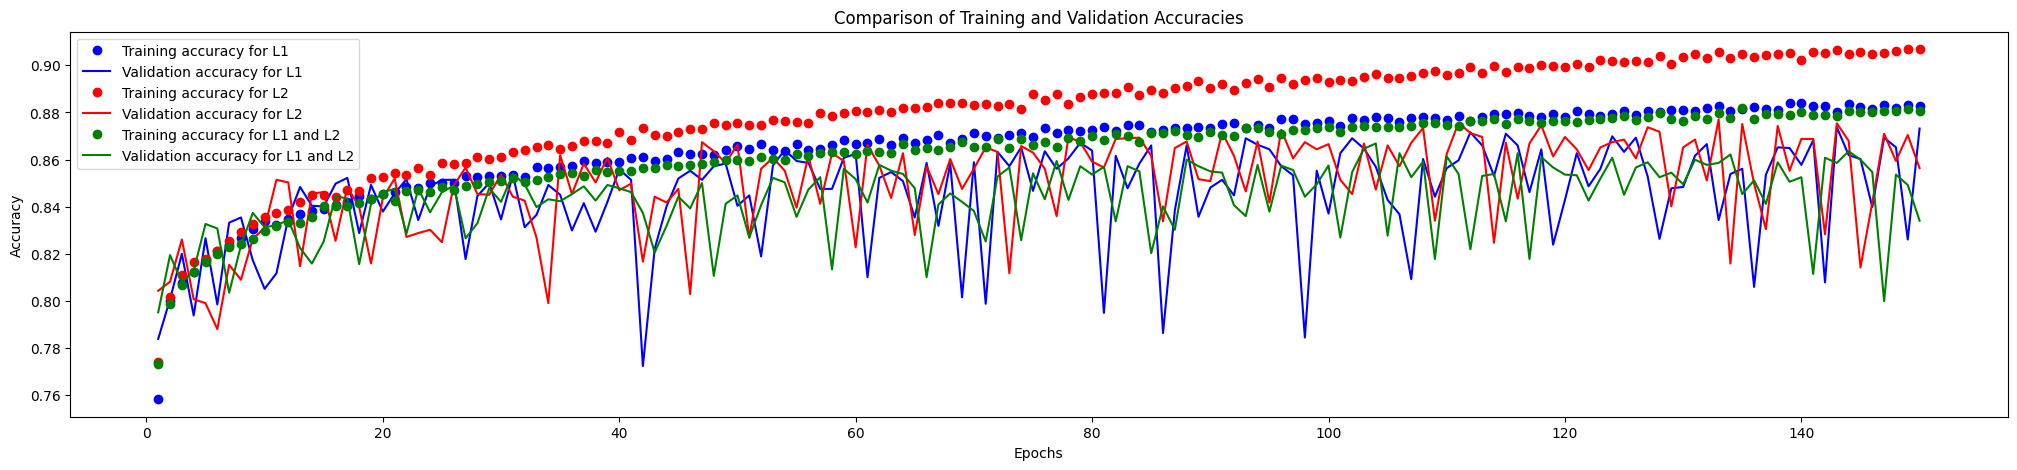

In [224]:
plot_accuracy_comparison(history_h1, history_h2, history_h1_h2, labels=['L1', 'L2', 'L1 and L2'])

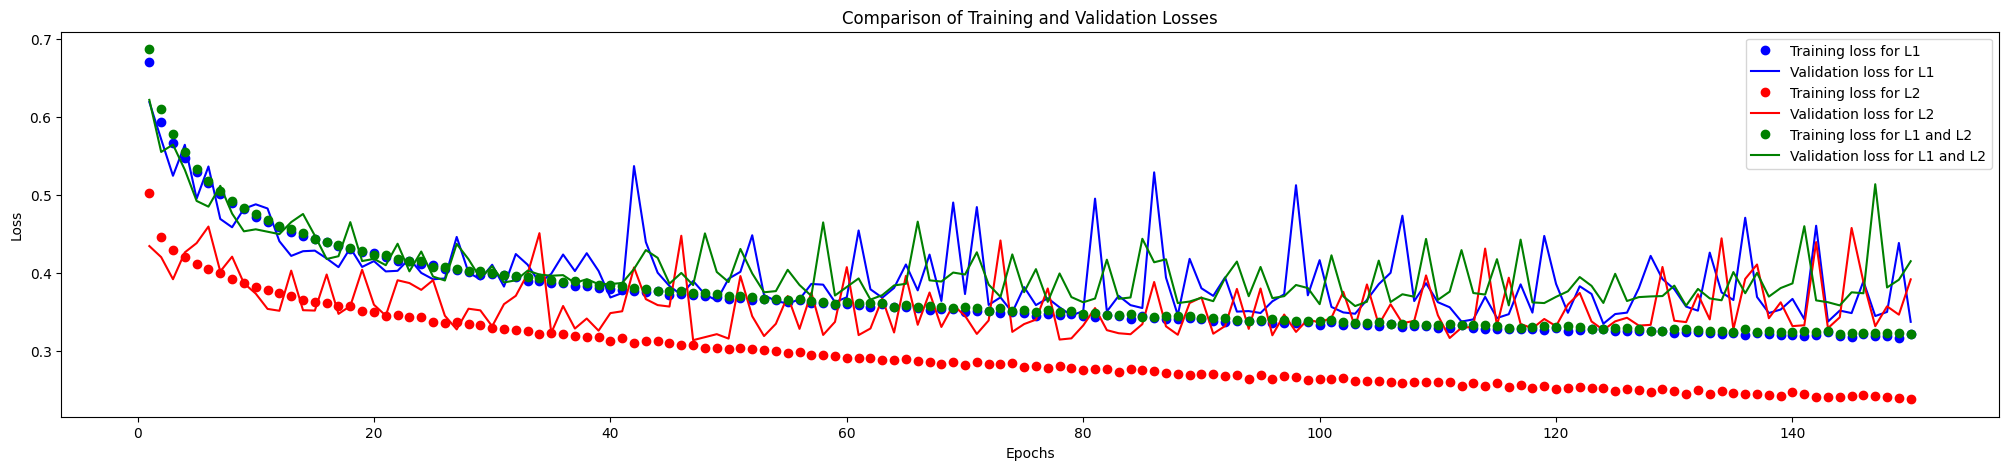

In [225]:
plot_loss_comparison(history_h1, history_h2, history_h1_h2, labels=['L1', 'L2', 'L1 and L2'])

## Dropout

In [226]:
def createNNModelWithDropout(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16, kernel_regularizer=None, dropout_rate: float = 0.5):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [227]:
model_dropout_1 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0)
model_dropout_2 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.1)
model_dropout_3 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.3)
model_dropout_4 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.5)

In [228]:
history_dropout_1 = model_dropout_1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_2 = model_dropout_2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_3 = model_dropout_3.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_4 = model_dropout_4.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7252 - loss: 0.5752 - val_acc: 0.7998 - val_loss: 0.4341
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7935 - loss: 0.4537 - val_acc: 0.8227 - val_loss: 0.3981
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8043 - loss: 0.4375 - val_acc: 0.8053 - val_loss: 0.4221
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8143 - loss: 0.4170 - val_acc: 0.7803 - val_loss: 0.4667
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8156 - loss: 0.4153 - val_acc: 0.7976 - val_loss: 0.4300
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8207 - loss: 0.4050 - val_acc: 0.8238 - val_loss: 0.3842
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8230 - loss: 0.4006 - val_acc: 0.7885 - val_loss: 0.4545
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8209 - loss: 0.4024 - val_acc: 0.8313 - val_loss: 0.3709
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8266

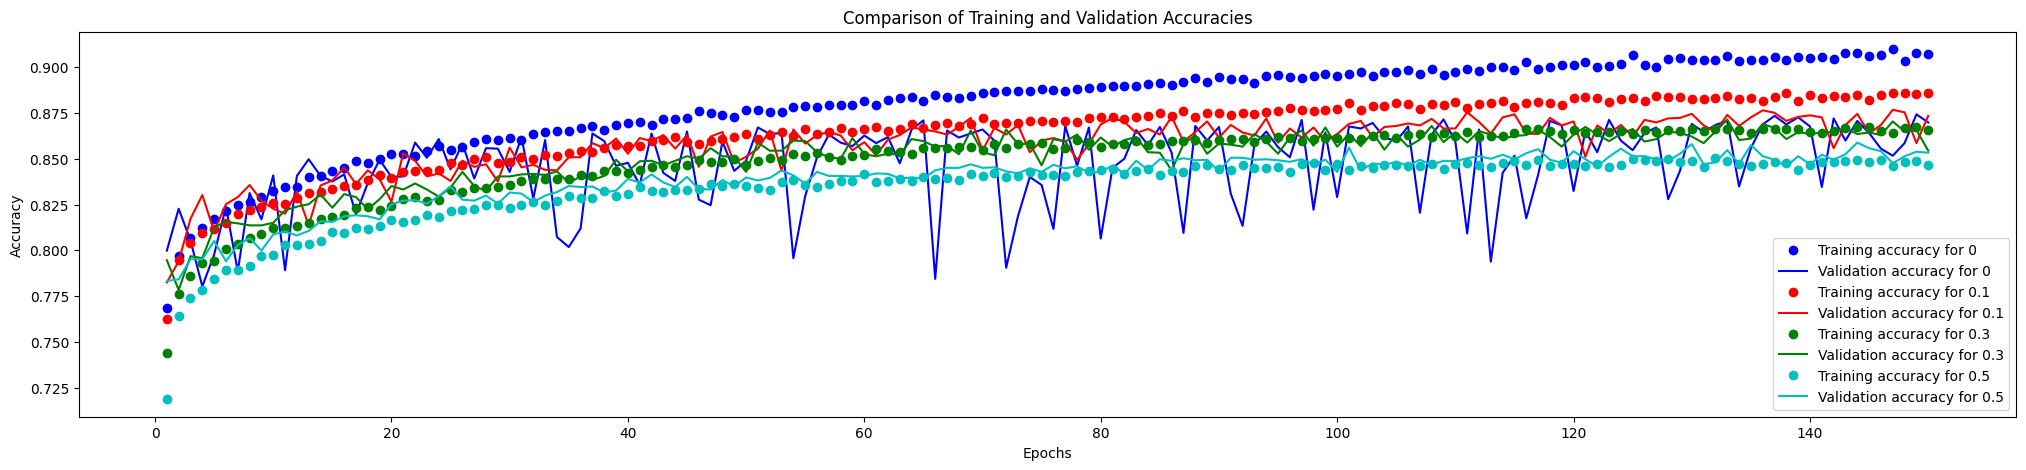

In [229]:
plot_accuracy_comparison(history_dropout_1, history_dropout_2, history_dropout_3, history_dropout_4, labels=['0', '0.1', '0.3', '0.5'])

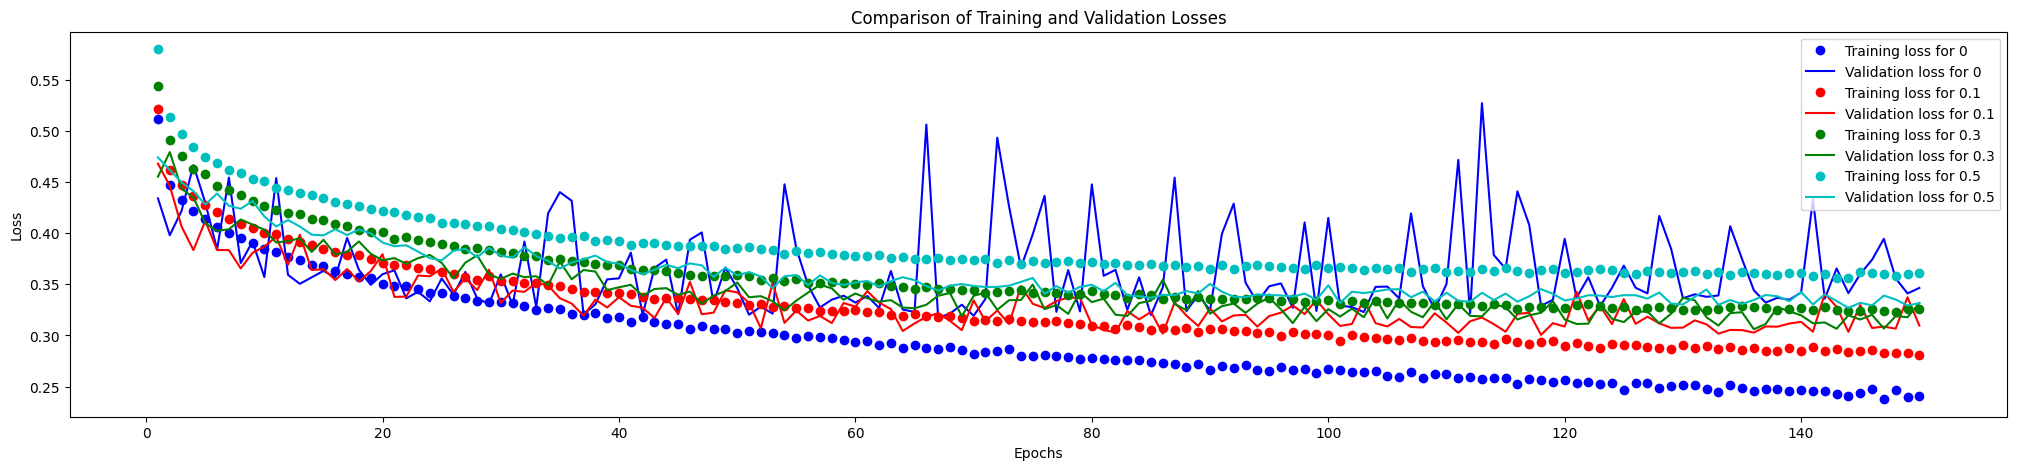

In [230]:
plot_loss_comparison(history_dropout_1, history_dropout_2, history_dropout_3, history_dropout_4, labels=['0', '0.1', '0.3', '0.5'])